In [1]:
# import necessary stuff
import numpy as np
# import tensorflow as tf
import scipy.sparse as sp
import pickle
import pandas as pd
import os.path
import h5py
import datetime
import pytz
import matplotlib.pyplot as plt

In [2]:
timezone = pytz.timezone("Asia/Jakarta")
now = datetime.datetime.now(timezone).strftime("%Y-%m-%d_%H-%M-%S")
print(now)

2024-01-17_03-26-56


In [3]:
class Solver(object):
    """
    Class for solving 3d Schrodinger equation with arbitrary potentials
    """
    def __init__(self, L, number, ions=5, filename='3d_hydrogenLike_data.h5'):
        self.ions = ions

        self.L = L
        self.limit = (L-1)*0.4/2
        self.number = number
        self.theor_energies = np.array([
            0.5, 1.99981599747, 4.500114696, 8.001010409, 12.503075713, 18.006918257, 24.51349342, 32.02372367
        ])*-1

        self.index = []

        for i in range(self.ions):
            self.index.append(int(self.number/self.ions)*[i+1])

        self.index = np.array(self.index).flatten()
        np.random.shuffle(self.index)

        self.filename = filename

        self.L = L
        self.dx = 0.0
        self.mesh = None

        self.list_h = {"1": 0.29, "2": 0.14, "3": 0.10, "4": 0.07, "5": 0.06, "6": 0.05, "7": 0.04, "8": 0.04}

    def getMesh(self, L, limit):
        x = np.linspace(-limit, limit, L)
        y = np.linspace(-limit, limit, L)
        z = np.linspace(-limit, limit, L)

        #grid spacing
        dx = x[1]-x[0]
        mesh = np.meshgrid(x, y, z)
        return dx, mesh

    def T(self, limit, L, dx):
        diag = np.ones([L])
        diags = np.array([diag, -2*diag, diag])
        D = sp.spdiags(diags, np.array([-1, 0,1]), L, L)/dx/dx
        D1 = sp.kronsum(D,D)
        D2 = sp.kronsum(D1,D)
        T = -0.5 * D2
        return T

    def solve(self, potential, limit, dx):
        T = self.T(limit, self.L, dx)
        V = potential
        H = T + V
        E, psi = sp.linalg.eigsh(H, k=1, which='SA')
        return E, psi

    def potential_generator(self, args):
        mesh, L, cx, cy, cz, Z, return_image = args
        (x,y,z) = mesh
        potential = -Z/np.sqrt((x-cx)**2 + (y-cy)**2 + (z-cz)**2)
        V = sp.diags(potential.reshape(L**3),(0), )
        if return_image==True:
            return potential
        else:
            return V, potential

    def generate_file(self):
        if os.path.isfile(self.filename):
            with h5py.File(self.filename, 'r') as F:
                Zs = F['Z'][...]
                data = F['potential'][...]
                labels = F['energy'][...]
                cx = F['cx'][...]
                cy = F['cy'][...]
                cz = F['cz'][...]
        else:
            data = np.zeros((self.number, self.L, self.L, self.L, 1))
            labels = np.zeros((self.number, 1))
            cxs = []; cys = []; czs = []; Zs = [];
            num = 0

            while num<self.number:
                for index in self.index:
                    Zs.append(index)
                    grid_spacing = self.list_h[str(index)]
                    limit = (L-1)*grid_spacing/2
                    cx, cy, cz = np.random.uniform(-grid_spacing/2, grid_spacing/2, 3)
                    while np.sqrt(cx**2 + cy**2 + cz**2) > grid_spacing:
                        cx, cy, cz = np.random.uniform(-grid_spacing/2, grid_spacing/2, 3)

                    dx, mesh = self.getMesh(L, limit)
                    args = (mesh, L, cx, cy, cz, index, False)
                    V, potential = self.potential_generator(args)
                    E, psi = self.solve(V, limit, dx)
                    energy = E[0]

                    while (energy<self.theor_energies[index-1]):
                        cx, cy, cz = np.random.uniform(-grid_spacing/2, grid_spacing/2, 3)
                        while np.sqrt(cx**2 + cy**2 + cz**2) > grid_spacing:
                            cx, cy, cz = np.random.uniform(-grid_spacing/2, grid_spacing/2, 3)

                        args = (mesh, L, cx, cy, cz, index, False)
                        V, potential = self.potential_generator(args)
                        E, psi = self.solve(V, limit, dx)
                        energy = E[0]
    #                         print(index, "non", energy)

                    data[num,:,:,:,0] = potential
                    labels[num,0] = energy
                    num += 1
    #                     print(index, "yes", energy)
                    print(f"num: {num}", end="\r")
                    cxs.append(cx)
                    cys.append(cy)
                    czs.append(cz)

            cxs = np.array(cxs)
            cys = np.array(cys)
            czs = np.array(czs)
            Zs = np.array(Zs)

            with h5py.File(self.filename, 'w') as F:
                F.create_dataset('Z', data=Zs, compression='gzip')
                F.create_dataset('potential', data=data, compression='gzip')
                F.create_dataset('energy', data=labels, compression='gzip')
                F.create_dataset('cx', data=cxs, compression='gzip')
                F.create_dataset('cy', data=cys, compression='gzip')
                F.create_dataset('cz', data=czs, compression='gzip')

        return Zs, data, labels
        # return data, labels

In [4]:
L = 64
S = Solver(L=L, number=1, ions=1, filename=f"3d_schrodinger_data_2023-06-20_13-44-54.h5")
charge, data, labels = S.generate_file()
# data, labels = S.generate_file()

In [5]:
data = data.reshape(L, L, L)

In [6]:
limit = (L-1)*0.4/2
x = np.linspace(-limit, limit, L)
X, Y, Z = np.meshgrid(x, x, x)

def plot(imgs):
  # plot
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlim(-limit, limit)
  ax.set_ylim(-limit, limit)
  ax.set_zlim(-limit, limit)
  # ax.set_xlabel('X')
  # ax.set_ylabel('Y')
  # ax.set_zlabel('Z')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])

  alphas = []
  index = []

  for i in range(imgs.flatten().shape[0]):
    if imgs.flatten()[i] < -5:
      alphas.append(1)
    else:
      alphas.append(0.03)

  im = ax.scatter(X, Y, Z, c=imgs, cmap='viridis',  s=3, rasterized=True, alpha=alphas)
  # add colorbar
  # cbar = fig.colorbar(im, ax=ax, shrink=0.5)
  # cbar.solids.set(alpha=1)
  plt.savefig('../fig/hyd_like.svg', transparent=True, bbox_inches='tight', pad_inches=0)
  plt.show()

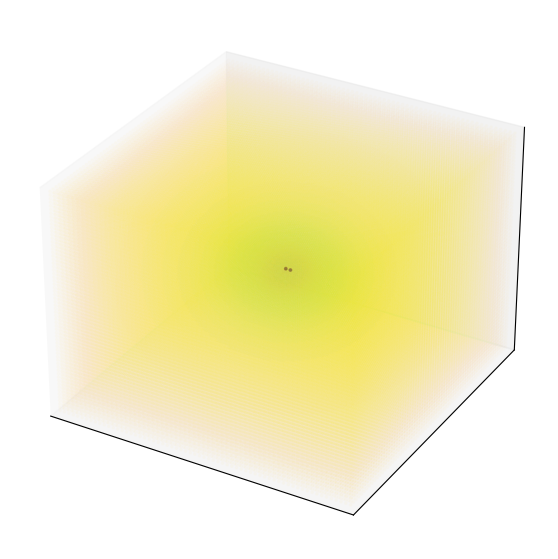

In [7]:
plot(data)